In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import VimeoVideo
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils.validation import check_is_fitted
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/survey-of-consumer-finances-data/SCFP2019.csv
/kaggle/input/data-dictionary-for-customer-segmentation-usa/hcbk.htm


`Prepare Data`

1. Import



Just like always, we need to begin by bringing our data into the project. We spent some time in the previous lesson working with a subset of the larger SCF dataset called "TURNFEAR". Let's start with that.

Task 6.2.1: Create a wrangle function that takes a path of a CSV file as input, reads the file into a DataFrame, subsets the data to households that have been turned down for credit or feared being denied credit in the past 5 years (see "TURNFEAR"), and returns the subset DataFrame.

In [2]:
def wrangle(filepath):
    df = pd.read_csv(filepath)  # Read CSV file into DataFrame
    
    mask = df["TURNFEAR"] == 1  # Create boolean mask
    
    df = df[mask]  # Apply mask to filter DataFrame
    
    return df  # Return filtered DataFrame

And now that we've got that taken care of, we'll import the data and see what we've got.

Task 6.2.2: Use your wrangle function to read the file SCFP2019.csv.gz into a DataFrame named df.

In [3]:

# Call the wrangle function to load and process data
df = wrangle("/kaggle/input/survey-of-consumer-finances-data/SCFP2019.csv")

# Print type and shape of the DataFrame
print("df type:", type(df))
print("df shape:", df.shape)

# Display the first few rows of the DataFrame
df.head()

df type: <class 'pandas.core.frame.DataFrame'>
df shape: (4623, 356)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
5,2,21,3790.476607,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
6,2,22,3798.868505,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,3,2,2
7,2,23,3799.468393,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
8,2,24,3788.076005,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
9,2,25,3793.066589,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2


`2. Explore`

Task 6.2.3: Create a scatter plot of that shows the total value of primary residence of a household ("HOUSES") as a function of the total value of household debt ("DEBT"). Be sure to label your x-axis as "Household Debt", your y-axis as "Home Value", and use the title "Credit Fearful: Home Value vs. Household Debt".

In [4]:
(df["DEBT"] / 1e6).head(10)

5      0.014142
6      0.014606
7      0.017736
8      0.016345
9      0.017852
110    0.000000
111    0.000000
112    0.000000
113    0.000000
114    0.000000
Name: DEBT, dtype: float64

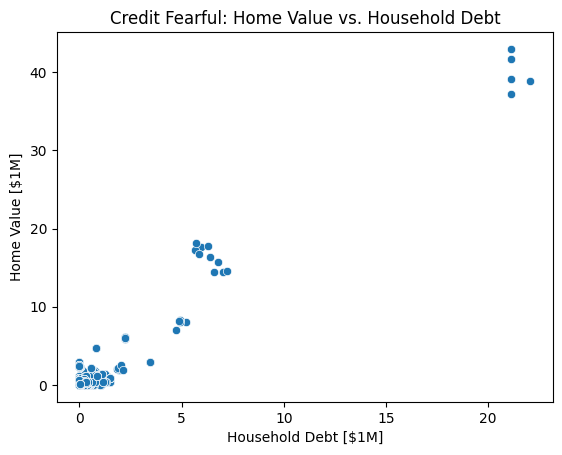

In [5]:
# Plot "HOUSES" vs "DEBT"
sns.scatterplot(x=df["DEBT"]/ 1e6, y=df["HOUSES"]/ 1e6)

plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

`3. Split`

We need to split our data, but we're not going to need target vector or a test set this time around. That's because the model we'll be building involves unsupervised learning. It's called unsupervised because the model doesn't try to map input to a st of labels or targets that already exist. It's kind of like how humans learn new skills, in that we don't always have models to copy. Sometimes, we just try out something and see what happens. Keep in mind that this doesn't make these models any less useful, it just makes them different.

So, keeping that in mind, let's do the split.

Task 6.2.4: Create the feature matrix X. It should contain two features only: "DEBT" and "HOUSES".

In [6]:
X = df[["DEBT", "HOUSES"]]

print("X type:", type(X))
print("X shape:", X.shape)
X.head()

X type: <class 'pandas.core.frame.DataFrame'>
X shape: (4623, 2)


,DEBT,HOUSES
5,14142.304636,0.0
6,14605.986755,0.0
7,17735.841060,0.0
8,16344.794702,0.0
9,17851.761589,0.0


`4. Build Model`

`5. Iterate`

Task 6.2.7: Build a KMeans model, assign it to the variable name model, and fit it to the training data X.

In [7]:
# Build model
model = KMeans(n_clusters=3, random_state=42)
print("model type:", type(model))

# Fit model to data
model.fit(X)

# Assert that model has been fit to data
# check_is_fitted(model)

model type: <class 'sklearn.cluster._kmeans.KMeans'>


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

And there it is. 42 datapoints spread across three clusters. Let's grab the labels that the model has assigned to the data points so we can start making a new visualization.

Task 6.2.8: Extract the labels that your model created during training and assign them to the variable labels.

In [8]:
# Accessing labels from the model
labels = model.labels_

# Printing the type of labels
print("labels type:", type(labels))

# Printing the shape of labels
print("labels shape:", labels.shape)

# Displaying the first 10 labels
labels[:10]


labels type: <class 'numpy.ndarray'>
labels shape: (4623,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Using the labels we just extracted, let's recreate the scatter plot from before, this time we'll color each point according to the cluster to which the model assigned it.

Task 6.2.9: Recreate the "Home Value vs. Household Debt" scatter plot you made above, but with two changes. First, use seaborn to create the plot. Second, pass your labels to the hue argument, and set the palette argument to "deep".

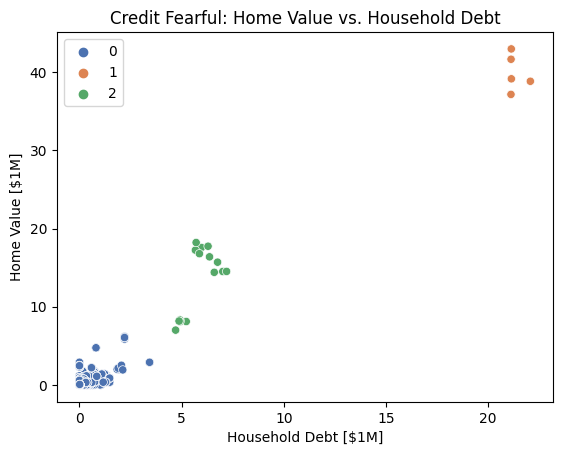

In [9]:
# Scatter plot with scaled debt and house values
sns.scatterplot(
    x=df["DEBT"] / 1e6,  # x-axis: debt in millions
    y=df["HOUSES"] / 1e6,  # y-axis: house values in millions
    hue=labels,  # color by label
    palette="deep"  # use deep color palette
)

plt.xlabel("Household Debt [$1M]")  # x-axis label
plt.ylabel("Home Value [$1M]")  # y-axis label
plt.title("Credit Fearful: Home Value vs. Household Debt");  # plot title

Nice! Each cluster has its own color. The centroids are still missing, so let's pull those out.

Task 6.2.10: Extract the centroids that your model created during training, and assign them to the variable centroids.

In [10]:
# Get cluster centers
centroids = model.cluster_centers_

# Print type of centroids
print("centroids type:", type(centroids))

# Print shape of centroids
print("centroids shape:", centroids.shape)

# Display centroids
centroids


centroids type: <class 'numpy.ndarray'>
centroids shape: (3, 2)


array([[  105508.05824359,   134642.03534343],
       [21310946.1192    , 39974035.4966    ],
       [ 5872302.19867333, 13524061.81013334]])

Task 6.2.11: Recreate the seaborn "Home Value vs. Household Debt" scatter plot you just made, but with one difference: Add the centroids to the plot. Be sure to set the centroids color to "gray".

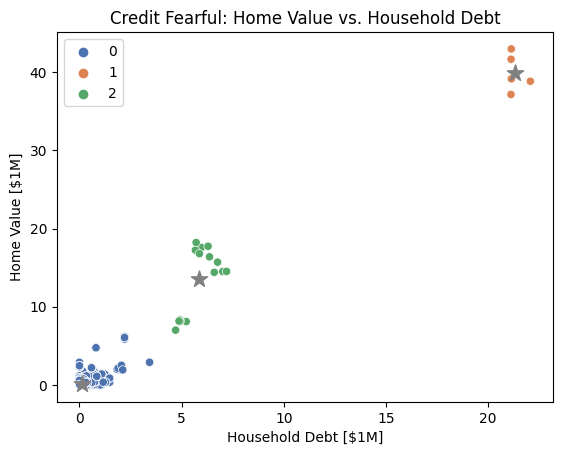

In [11]:
# Scatter plot "HOUSES" vs "DEBT"
sns.scatterplot(
    x=df["DEBT"]/ 1e6,  # Debt in $1M
    y=df["HOUSES"]/ 1e6,  # Home value in $1M
    hue=labels,  # Cluster labels
    palette="deep"
)

# Add centroids
plt.scatter(
    x=centroids[:, 0] / 1e6,  # Centroid's debt in $1M
    y=centroids[:, 1] / 1e6,  # Centroid's home value in $1M
    color="gray",
    marker="*",
    s=150
)

# Set labels
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");


That looks great, but let's not pat ourselves on the back just yet. Even though our graph makes it look like the clusters are correctly assigned but, as data scientists, we need a numerical evaluation. The data we're using is pretty clear-cut, but if things were a little more muddled, we'd want to run some calculations to make sure we got everything right.

There are two metrics that we'll use to evaluate our clusters. We'll start with inertia, which measure the distance between the points within the same cluster.

Task 6.2.12: Extract the inertia for your model and assign it to the variable inertia.

In [12]:
# Get inertia from the model
inertia = model.inertia_

# Print the type of inertia
print("inertia type:", type(inertia))

# Print inertia value for 3 clusters
print("Inertia (3 clusters):", inertia)


inertia type: <class 'float'>
Inertia (3 clusters): 1262532206483913.0


The "best" inertia is 0, and our score is pretty far from that. Does that mean our model is "bad?" Not necessarily. Inertia is a measurement of distance (like mean absolute error from Project 2). This means that the unit of measurement for inertia depends on the unit of measurement of our x- and y-axes. And since "DEBT" and "HOUSES" are measured in tens of millions of dollars, it's not surprising that inertia is so large.

However, it would be helpful to have metric that was easier to interpret, and that's where silhouette score comes in. Silhouette score measures the distance between different clusters. It ranges from -1 (the worst) to 1 (the best), so it's easier to interpret than inertia. WQU WorldQuant University Applied Data Science Lab QQQQ

Task 6.2.13: Calculate the silhouette score for your model and assign it to the variable ss.

In [13]:
ss = silhouette_score(X, model.labels_)
print("ss type:", type(ss))
print("Silhouette Score (3 clusters):", ss)

ss type: <class 'numpy.float64'>
Silhouette Score (3 clusters): 0.97688424629445


Outstanding! 0.976 is pretty close to 1, so our model has done a good job at identifying 3 clusters that are far away from each other.

It's important to remember that these performance metrics are the result of the number of clusters we told our model to create. In unsupervised learning, the number of clusters is hyperparameter that you set before training your model. So what would happen if we change the number of clusters? Will it lead to better performance? Let's try!

Task 6.2.14: Use a for loop to build and train a K-Means model where n_clusters ranges from 2 to 12 (inclusive). Each time a model is trained, calculate the inertia and add it to the list inertia_errors, then calculate the silhouette score and add it to the list silhouette_scores.

In [14]:
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    # build model
    model = KMeans(n_clusters=k, random_state=42)
    
    # Train model
    model.fit(X)
    
    # Calculate intertia
    inertia_errors.append(model.inertia_)
    
    # Calculate SS
    silhouette_scores.append(silhouette_score(X, model.labels_))

# print("inertia_errors type:", type(inertia_errors))
# print("inertia_errors len:", len(inertia_errors))
print("Inertia:", inertia_errors)
print()
# print("silhouette_scores type:", type(silhouette_scores))
# print("silhouette_scores len:", len(silhouette_scores))
print("Silhouette Scores:", silhouette_scores)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

Inertia: [4055509877242491.5, 1262532206483913.0, 733824099167179.5, 415637973082058.4, 316109943946167.6, 244867085128676.62, 202464902389464.47, 153620973481709.3, 134832918336089.8, 115872155481706.78, 100455550824623.27]

Silhouette Scores: [0.9855099957519449, 0.97688424629445, 0.9490311483407262, 0.8393300432423354, 0.7287406719885346, 0.7269891143043261, 0.7263840026873423, 0.7335125606462771, 0.6921579929520619, 0.6949309528526951, 0.6951831030976504]


Task 6.2.15: Create a line plot that shows the values of inertia_errors as a function of n_clusters. Be sure to label your x-axis "Number of Clusters", your y-axis "Inertia", and use the title "K-Means Model: Inertia vs Number of Clusters".

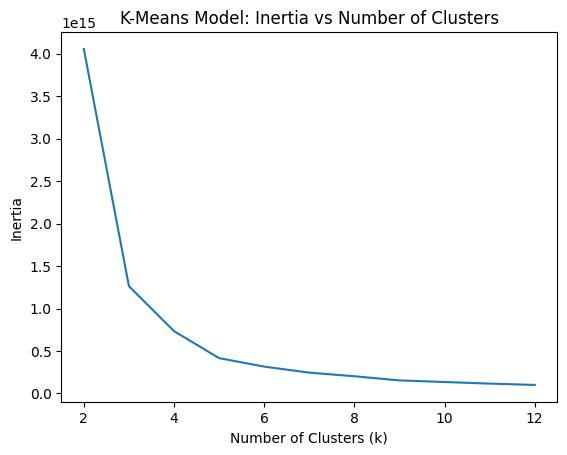

In [15]:
# Plot `inertia_errors` by `n_clusters`
plt.plot(n_clusters, inertia_errors)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("K-Means Model: Inertia vs Number of Clusters");


What we're seeing here is that, as the number of clusters increases, inertia goes down. In fact, we could get inertia to 0 if we told our model to make 4,623 clusters (the same number of observations in X), but those clusters wouldn't be helpful to us.

The trick with choosing the right number of clusters is to look for the "bend in the elbow" for this plot. In other words, we want to pick the point where the drop in inertia becomes less dramatic and the line begins to flatten out. In this case, it looks like the sweet spot is 4 or 5.

Let's see what the silhouette score looks like.

Task 6.2.16: Create a line plot that shows the values of silhouette_scores as a function of n_clusters. Be sure to label your x-axis "Number of Clusters", your y-axis "Silhouette Score", and use the title "K-Means Model: Silhouette Score vs Number of Clusters".

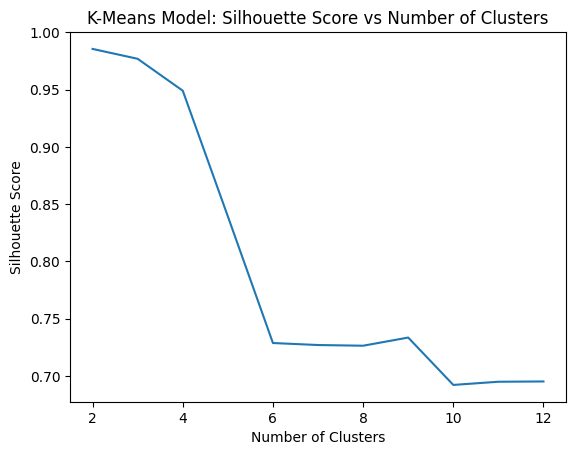

In [16]:
# Plot `silhouette_scores` vs `n_clusters`
plt.plot(n_clusters, silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("K-Means Model: Silhouette Score vs Number of Clusters");


Note that, in contrast to our inertia plot, bigger is better. So we're not looking for a "bend in the elbow" but rather a number of clusters for which the silhouette score still remains high. We can see that silhouette score drops drastically beyond 4 clusters. Given this and what we saw in the inertia plot, it looks like the optimal number of clusters is 4.

Now that we've decided on the final number of clusters, let's build a final model.

Task 6.2.17: Build and train a new k-means model named final_model. Use the information you gained from the two plots above to set an appropriate value for the n_clusters argument. Once you've built and trained your model, submit it to the grader for evaluation.

In [17]:
# Build model
final_model = KMeans(n_clusters=4, random_state=42)
print("final_model type:", type(final_model))

# Fit model to data
final_model.fit(X)

# Assert that model has been fit to data
# check_is_fitted(final_model)

final_model type: <class 'sklearn.cluster._kmeans.KMeans'>


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

`6. Communicate`

Task 6.2.18: Create one last "Home Value vs. Household Debt" scatter plot that shows the clusters that your final_model has assigned to the training data.

Text(0.5, 1.0, 'Credit Fearful: Home Value vs. Household Debt')

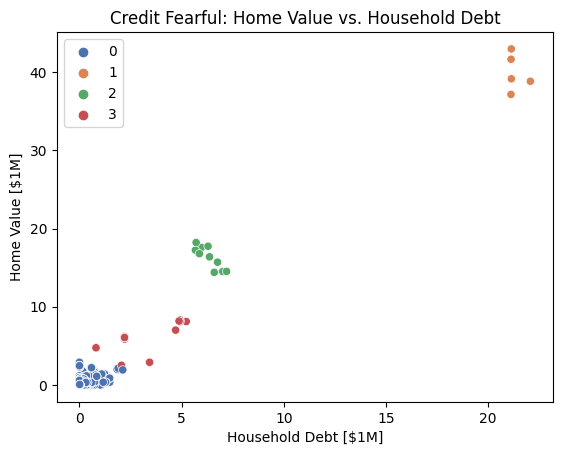

In [18]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Plot "HOUSES" vs "DEBT" with final_model labels
sns.scatterplot(
    x=df["DEBT"] / 1e6,  # x-axis: household debt in millions
    y=df["HOUSES"] / 1e6,  # y-axis: home value in millions
    hue=final_model.labels_,  # color by cluster labels
    palette="deep"  # set color palette
)
plt.xlabel("Household Debt [$1M]")  # x-axis label
plt.ylabel("Home Value [$1M]")  # y-axis label
plt.title("Credit Fearful: Home Value vs. Household Debt")  # plot title


Nice! You can see all four of our clusters, each differentiated from the rest by color.

We're going to make one more visualization, converting the cluster analysis we just did to something a little more actionable: a side-by-side bar chart. In order to do that, we need to put our clustered data into a DataFrame.

Task 6.2.19: Create a DataFrame xgb that contains the mean "DEBT" and "HOUSES" values for each of the clusters in your final_model.

In [19]:
xgb = X.groupby(final_model.labels_).mean()

# print("xgb type:", type(xgb))
# print("xgb shape:", xgb.shape)
xgb

,DEBT,HOUSES
0,9.840064e+04,1.196152e+05
1,2.131095e+07,3.997404e+07
2,6.344099e+06,1.631466e+07
3,2.806353e+06,5.276040e+06


Task 6.2.20: Create a side-by-side bar chart from xgb that shows the mean "DEBT" and "HOUSES" values for each of the clusters in your final_model. For readability, you'll want to divide the values in xgb by 1 million. Be sure to label the x-axis "Cluster", the y-axis "Value [$1 million]", and use the title "Mean Home Value & Household Debt by Cluster".

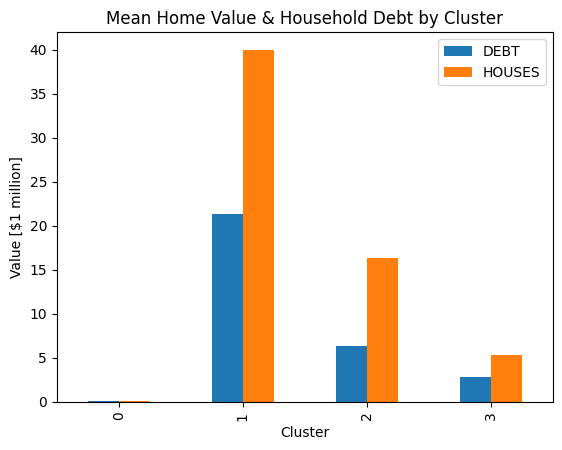

In [20]:
# Create side-by-side bar chart of `xgb`
(xgb / 1e6).plot(kind="bar")
plt.xlabel("Cluster")
plt.ylabel("Value [$1 million]")
plt.title("Mean Home Value & Household Debt by Cluster");

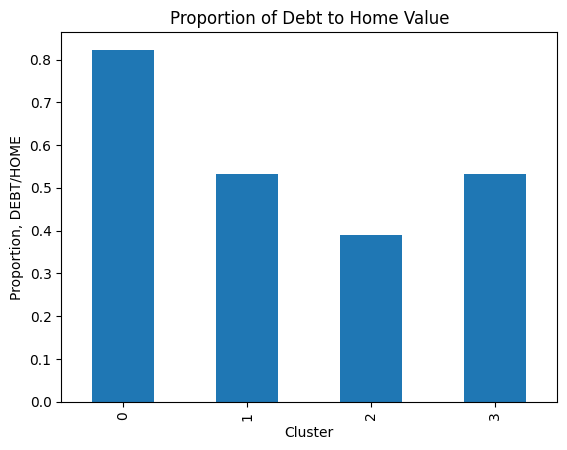

In [21]:
(xgb["DEBT"] / xgb["HOUSES"]).plot(
    kind="bar",
    xlabel="Cluster",
    ylabel="Proportion, DEBT/HOME",
    title="Proportion of Debt to Home Value"
);

In this plot, we have our four clusters spread across the x-axis, and the dollar amounts for home value and household debt on the y-axis.

The first thing to look at in this chart is the different mean home values for the five clusters. Clusters 0 represents households with small to moderate home values, clusters 2 and 3 have high home values, and cluster 1 has extremely high values.

The second thing to look at is the proportion of debt to home value. In clusters 1 and 3, this proportion is around 0.5. This suggests that these groups have a moderate amount of untapped equity in their homes. But for group 0, it's almost 1, which suggests that the largest source of household debt is their mortgage. Group 2 is unique in that they have the smallest proportion of debt to home value, around 0.4.

This information could be useful to financial institution that want to target customers with products that would appeal to them. For instance, households in group 0 might be interested in refinancing their mortgage to lower their interest rate. Group 2 households could be interested in a home equity line of credit because they have more equity in their homes. And the bankers, Bill Gates, and Beyoncés in group 1 might want white-glove personalized wealth management.